In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time
import rebound
import matplotlib.pyplot as plt
import numpy as np
import eccentricWH_bruteforce_2body
import vanillaWH_bruteforce_nbody
import integrator_tools

%matplotlib inline

# configuring plots
#plt.rc('text', usetex=True)            # use LaTeX for text
plt.rc('font', family='serif')          # use serif font
plt.rcParams.update({'font.size': 14})  # increase font size

In [3]:
test_sim2 = rebound.Simulation()
test_sim2.add(m=1.)
test_sim2.add(m=1e-3, a=1., e=0.)
test_sim2.particles[1]

<rebound.particle.Particle object at 0x7fc8646e67c0, m=0.001 x=1.0 y=0.0 z=0.0 vx=0.0 vy=1.000499875062461 vz=0.0>

In [31]:
p0 = np.array([0., 0., 0., 0., 0., 0., 10.])
p1 = np.array([1., 0., 0., 0., 1.00049987506246, 0., 1e-3])
sim_jacobi = np.stack([p0, p1])

masses = sim_jacobi[:,-1]

sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)

test_sim = rebound.Simulation()
test_sim.add(x=sim[0,0], y=sim[0,1], z=sim[0,2], vx=sim[0,3], vy=sim[0,4], vz=sim[0,5], m=sim[0,6])
test_sim.add(x=sim[1,0], y=sim[1,1], z=sim[1,2], vx=sim[1,3], vy=sim[1,4], vz=sim[1,5], m=sim[1,6])
test_sim.move_to_com()

print(test_sim.particles[1].a,test_sim.particles[1].e)

0.526340718909531 0.8999100089991003


In [98]:
### SETUP ###

# (1) Initial conditions from Mikkola 1997
# particle array as [x, y, z, vx, vy, vz, m]
#p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
#p1 = np.array([-2., 0., 0., 0., -0.7, 0., 2.])
#p2 = np.array([0., 60., 0.01, -0.095, 0.0, 0.01, 0.9])

p0 = np.array([0., 0., 0., 0., 0., 0., 10.])
p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])
sim_jacobi = np.stack([p0, p1])
masses = sim_jacobi[:,-1]

sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)
total_mass = np.sum(sim[:,6])
# Calculate Jacobi masses
sim_jacobi = integrator_tools.inertial_to_jacobi(sim)

# (2) Number of orbits and steps per orbit
N_orbits = 100
steps_per_orbit = 20

# Calculate semi-major axis of binary
test_sim = rebound.Simulation()
test_sim.add(x=sim[0,0], y=sim[0,1], z=sim[0,2], vx=sim[0,3], vy=sim[0,4], vz=sim[0,5], m=sim[0,6])
test_sim.add(x=sim[1,0], y=sim[1,1], z=sim[1,2], vx=sim[1,3], vy=sim[1,4], vz=sim[1,5], m=sim[1,6])

binary_period = 2*np.pi*np.sqrt(test_sim.particles[1].a**3 / total_mass)
timestep = 1./steps_per_orbit * binary_period
N_steps = N_orbits*steps_per_orbit

# (3) Time transform parameters
time_transform = True
A1 = 1.
#time_array = np.zeros(N_steps)
#physical_time = 0.

### SETUP END ###

# Calculate value of non-time-transformed Hamiltonian at time 0

# Calculate norm of Jacobi coordinate and velocity
r1 = np.sqrt(sim_jacobi[1,0]**2 + sim_jacobi[1,1]**2 + sim_jacobi[1,2]**2)
v1_squared = sim_jacobi[1,3]**2 + sim_jacobi[1,4]**2 + sim_jacobi[1,5]**2

Kepler_term1 = 0.5*v1_squared - total_mass/r1
p0 = -Kepler_term1

time_transform_array = np.zeros(N_steps)
energy_error = np.zeros(N_steps)
E0 = integrator_tools.energy_fn(sim)

orbit_soln = np.zeros((len(sim_jacobi), 3, N_steps)) # [object, position, N_steps]
orbit_soln[:,0,0], orbit_soln[:,1,0], orbit_soln[:,2,0] = sim_jacobi[:,0], sim_jacobi[:,1], sim_jacobi[:,2]

start = time.time()

print('integrating...')

for i in range(N_steps):
    
    # print integration progress
    if i % int(N_steps/10) == 0:
        print(int(100*i/N_steps), '%')

    # drift
    if time_transform:
        sim_jacobi = eccentricWH_bruteforce_2body.drift(sim_jacobi, sim, A1, p0, h=timestep)
    else:
        sim_jacobi = vanillaWH_bruteforce_nbody.drift(sim_jacobi, sim, h=timestep)
    sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)
    
    # kick
    #sim_jacobi = eccentricWH_bruteforce.kick(sim_jacobi, sim, A1, h=timestep)
    
    # drift
    #sim_jacobi = eccentricWH_bruteforce.drift(sim_jacobi, sim, A1, p0, h=timestep/2)
    #sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)

    separation = np.sqrt(sim_jacobi[1,0]**2 + sim_jacobi[1,1]**2 + sim_jacobi[1,2]**2)
    time_transform_array[i] = separation/A1
    E = integrator_tools.energy_fn(sim)
    energy_error[i] = np.abs((E-E0)/E0)

    orbit_soln[:, 0, i] = sim_jacobi[:,0]
    orbit_soln[:, 1, i] = sim_jacobi[:,1]
    orbit_soln[:, 2, i] = sim_jacobi[:,2]
    #time_array[i] = physical_time

end = time.time()

print('time to integrate =', np.round(end - start, 1), 's')

orbit_soln_transform = np.copy(orbit_soln)
energy_error_transform = np.copy(energy_error)

integrating...
0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
time to integrate = 1.2 s


In [99]:
### SETUP (no time transform) ###

# (1) Initial conditions from Mikkola 1997
# particle array as [x, y, z, vx, vy, vz, m]
#p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
#p1 = np.array([-2., 0., 0., 0., -0.7, 0., 2.])
#p2 = np.array([0., 60., 0.01, -0.095, 0.0, 0.01, 0.9])

p0 = np.array([0., 0., 0., 0., 0., 0., 10.])
p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])
sim_jacobi = np.stack([p0, p1])
masses = sim_jacobi[:,-1]

sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)
total_mass = np.sum(sim[:,6])
# Calculate Jacobi masses
sim_jacobi = integrator_tools.inertial_to_jacobi(sim)

# (3) Time transform parameters
time_transform = False

### SETUP END ###

energy_error = np.zeros(N_steps)
E0 = integrator_tools.energy_fn(sim)

orbit_soln = np.zeros((len(sim_jacobi), 3, N_steps)) # [object, position, N_steps]
orbit_soln[:,0,0], orbit_soln[:,1,0], orbit_soln[:,2,0] = sim_jacobi[:,0], sim_jacobi[:,1], sim_jacobi[:,2]

start = time.time()

for i in range(N_steps):
    
    # drift
    if time_transform:
        sim_jacobi, time = eccentricWH_bruteforce.drift(sim_jacobi, sim, A1, p0, h=timestep)
    else:
        sim_jacobi = vanillaWH_bruteforce_nbody.drift(sim_jacobi, sim, h=timestep)
    sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)
    
    # kick
    #sim_jacobi = eccentricWH_bruteforce.kick(sim_jacobi, sim, A1, h=timestep)
    
    # drift
    #sim_jacobi = eccentricWH_bruteforce.drift(sim_jacobi, sim, A1, p0, h=timestep/2)
    #sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)
    
    E = integrator_tools.energy_fn(sim)
    energy_error[i] = np.abs((E-E0)/E0)

    orbit_soln[:, 0, i] = sim_jacobi[:,0]
    orbit_soln[:, 1, i] = sim_jacobi[:,1]
    orbit_soln[:, 2, i] = sim_jacobi[:,2]

end = time.time()

print('time to integrate =', np.round(end - start, 1), 's')


time to integrate = 1.4 s


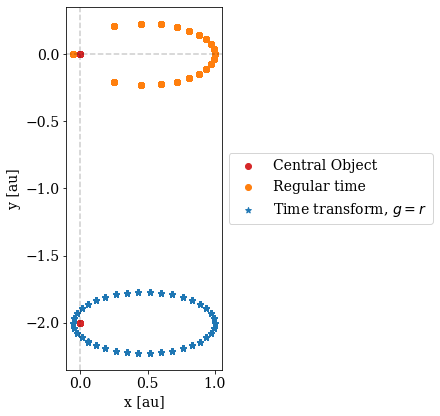

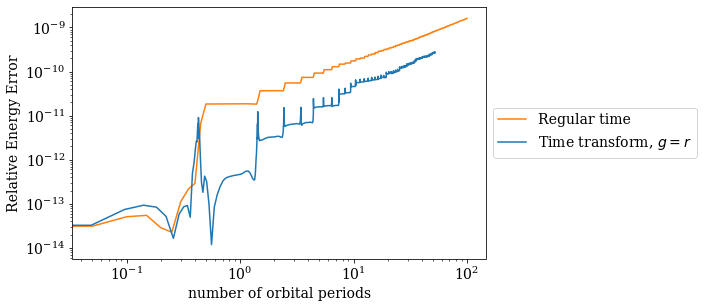

In [100]:
# testing

orbital_periods = timestep*np.arange(N_steps)/ binary_period

orbital_periods_transform = np.zeros(len(orbital_periods))

current_time = 0
for i in range(1, len(orbital_periods)):
    current_time += time_transform_array[i]*(1/steps_per_orbit)
    orbital_periods_transform[i] = current_time

plt.figure(figsize=(10,6))
plt.scatter(orbit_soln[0,0], orbit_soln[0,1], label='Central Object', c='tab:red')
plt.scatter(orbit_soln[0,0], orbit_soln[0,1]-2, c='tab:red')
plt.scatter(orbit_soln[1,0], orbit_soln[1,1], label='Regular time', c='tab:orange')
plt.scatter(orbit_soln_transform[1,0], orbit_soln_transform[1,1]-2, label='Time transform, $g=r$', marker='*', c='tab:blue')
plt.axhline(0, ls='--', alpha=0.2, c='black')
plt.axvline(0, ls='--', alpha=0.2, c='black')
plt.axis('scaled')
plt.xlabel('x [au]')
plt.ylabel('y [au]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('comparison.jpg', dpi=300)
plt.show() 

plt.figure(figsize=(10,4.5))
plt.loglog(orbital_periods, energy_error, label='Regular time', c='tab:orange')
plt.loglog(orbital_periods_transform, energy_error_transform, label='Time transform, $g=r$', c='tab:blue')
#plt.ylim(-6e-5, 6e-5)
plt.xlabel('number of orbital periods')
plt.ylabel('Relative Energy Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('SS_energy_error.jpg', dpi=300)
plt.show()
